# Simulating the Golenetskii correlation with popsynth

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import popsynth
from popsynth.aux_samplers.trunc_normal_aux_sampler import TruncatedNormalAuxSampler
from popsynth.aux_samplers.lognormal_aux_sampler import LogNormalAuxSampler

/Users/fran/.virtualenvs/grb/lib/python3.7/site-packages/popsynth/distribution.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm as progress_bar


## GRB population

In [2]:
# redshift distribution
r0_true = 1. #1/20.
rise_true = 1.
decay_true = 4.0
peak_true = 1.5

# luminosity function
Lmin_true = 1e51
alpha_true = 1.5
r_max = 7.0


pop_gen = popsynth.populations.ParetoSFRPopulation(
    r0=r0_true,
    rise=rise_true,
    decay=decay_true,
    peak=peak_true,
    Lmin=Lmin_true,
    alpha=alpha_true,
    r_max=r_max,
)

## Auxiliary samplers

In [3]:
from aux_samplers import TDecaySampler, DurationSampler, LumSampler

In [4]:
trise = TruncatedNormalAuxSampler(name="trise", observed=False)
trise.lower=0.01
trise.upper=5.0
trise.mu=1
trise.tau=1.0

t90 = LogNormalAuxSampler(name="log_t90", observed=False)
t90.mu=10
t90.tau=0.25

Epeak = LogNormalAuxSampler(name="Epeak", observed=False)
Epeak.mu=300
Epeak.tau=0.4

tdecay = TDecaySampler()
duration = DurationSampler()
luminosity = LumSampler()

tdecay.set_secondary_sampler(t90)
tdecay.set_secondary_sampler(trise)
duration.set_secondary_sampler(t90)
luminosity.set_secondary_sampler(Epeak)

In [5]:
pop_gen.add_observed_quantity(tdecay)
pop_gen.add_observed_quantity(duration)
pop_gen.add_observed_quantity(luminosity)

registering auxilary sampler: tdecay
registering auxilary sampler: duration
registering derived luminosity sampler: luminosity


## Survey

In [6]:
population = pop_gen.draw_survey(no_selection=True, boundary=1e-2)

The volume integral is 38.111186



Expecting 32 total objects
Sampling: luminosity
luminosity is sampling its secondary quantities
Sampling: Epeak
Getting luminosity from derived sampler
Sampling: tdecay
tdecay is sampling its secondary quantities
Sampling: log_t90
Sampling: trise
Sampling: duration
duration is sampling its secondary quantities
Applying soft boundary



No Selection! Added back all objects
NO HIDDEN OBJECTS
Deteced 32 objects or to a distance of 3.08


Text(0, 0.5, '$L$ (erg/s)')

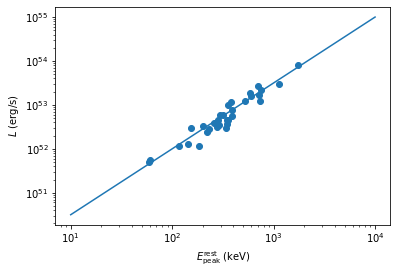

In [8]:
fig, ax = plt.subplots()
Egrid = 10**np.linspace(1, 4)

ax.scatter(10**population.Epeak, population.luminosities)
ax.plot(Egrid, 1e52 * np.power(Egrid/100, 1.5))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_\mathrm{peak}^\mathrm{rest}$ (keV)')
ax.set_ylabel('$L$ (erg/s)')

Text(0, 0.5, '$F_E$ (erg $\\mathrm{s}^{-1}$ $\\mathrm{cm}^{-2}$)')

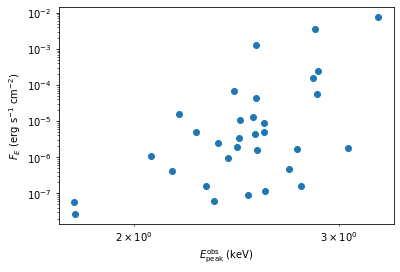

In [9]:
fig, ax = plt.subplots()
ax.scatter(population.Epeak_obs, population.flux_observed_all)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_\mathrm{peak}^\mathrm{obs}$ (keV)')
ax.set_ylabel('$F_E$ (erg $\mathrm{s}^{-1}$ $\mathrm{cm}^{-2}$)')

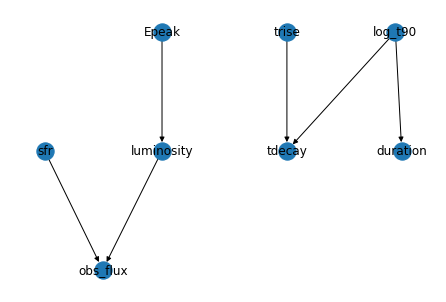

In [10]:
# Graph needs fixing for L-dependence
pos=nx.drawing.nx_agraph.graphviz_layout(pop_gen.graph, prog='dot')

nx.draw(pop_gen.graph, with_labels=True,pos=pos)